In [ ]:
import os
from IPython.display import display

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing import image
from google.colab import drive
from ipywidgets import IntProgress
import time

In [ ]:
drive.mount('drive')

Mounted at drive


## **Load and Split Dataset into training and validation**

In [ ]:
data_dir = os.path.join(os.getcwd(), 'drive', 'My Drive', 'parking_detection', 'parking_dataset_augmented')
img_width, img_height = (96, 96)
batch_size=16
validation_split = 0.2

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

print('\nLoad Testing Data')
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(os.getcwd(), 'drive', 'My Drive', 'parking_detection', 'test_data', 'testing_data'),
    seed=42,
    image_size=(img_height, img_width),
    batch_size=9
)

Found 3919 files belonging to 2 classes.
Using 3136 files for training.
Found 3919 files belonging to 2 classes.
Using 783 files for validation.

Load Testing Data
Found 16 files belonging to 2 classes.


# **Display sample of training set from dataset**

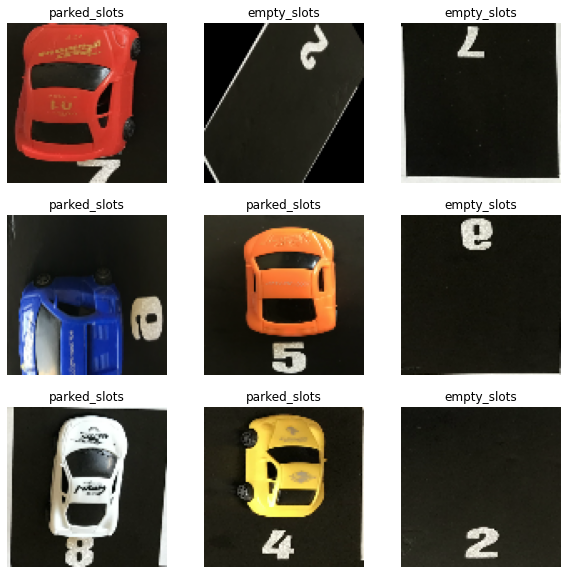

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

# **Define Sequential Model**

In [ ]:
model = Sequential()
model.add(
    ResNet50(
        include_top=False,input_tensor=None, input_shape=(96, 96, 3), pooling='avg', classes=2, weights='imagenet'
        )
    )
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    optimizer=SGD(lr=0.001),loss='binary_crossentropy',metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 24,768,385
Trainable params: 1,180,673
Non-trainable params: 23,587,712
__________________________________

# **Fit Data to model and save model**


In [ ]:
model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=4
)

model.save(os.path.join(os.getcwd(), 'drive', 'My Drive', 'parking_detection', 'models', 'parking_detection.h5'))

Epoch 1/4
196/196 [==============================] - 669s 3s/step - loss: 0.2865 - accuracy: 0.8897 - val_loss: 0.0251 - val_accuracy: 0.9987
Epoch 2/4
196/196 [==============================] - 134s 684ms/step - loss: 0.0755 - accuracy: 0.9758 - val_loss: 0.0120 - val_accuracy: 1.0000
Epoch 3/4
196/196 [==============================] - 134s 684ms/step - loss: 0.0494 - accuracy: 0.9857 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 4/4
196/196 [==============================] - 134s 683ms/step - loss: 0.0325 - accuracy: 0.9933 - val_loss: 0.0059 - val_accuracy: 1.0000


# **Load saved model**

In [ ]:
model = load_model(os.path.join(os.getcwd(), 'drive', 'My Drive', 'parking_detection', 'models', 'parking_detection.h5'))

# **Evaluate model accuracy with validation data**

In [ ]:
model.evaluate(validation_ds)

48/48 [==============================] - 310s 6s/step - loss: 0.6820 - accuracy: 0.9961


[0.6820036172866821, 0.9960681796073914]

# **Evaluate model accuracy with testing data**

In [ ]:
model.evaluate(testing_ds)

2/2 [==============================] - 0s 100ms/step - loss: 0.6834 - accuracy: 1.0000


[0.6834331154823303, 1.0]

# **Visualize model prediction with testing data**

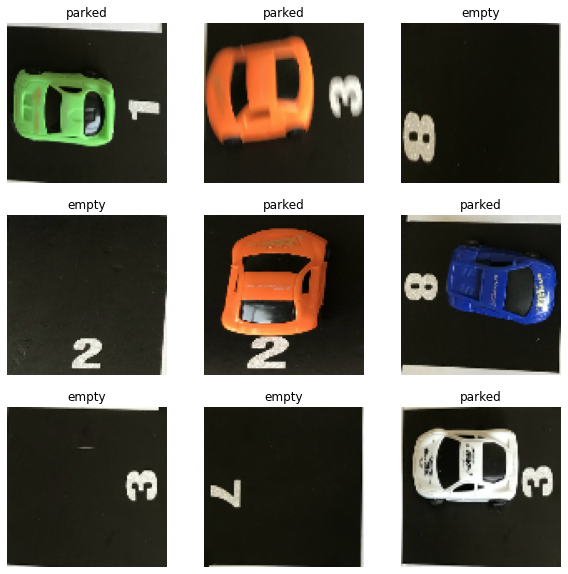

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in testing_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(['empty', 'parked'][int(round(model.predict(images[i].numpy().reshape(1, 96, 96, 3))[0][0]))])
    plt.axis("off")

# **Convert to 8 BIT quantized tflite model**

In [ ]:
IMAGE_SIZE = 96

def representative_data_gen():
    dataset_list = tf.data.Dataset.list_files(
        data_dir + '/*/*'
    )
    for i in range(100):
        image = next(iter(dataset_list))
        image = tf.io.read_file(image)
        image = tf.io.decode_png(image, channels=3)
        image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
        # image = tf.cast(image / 255., tf.float32)
        image = tf.expand_dims(image, 0)
        yield [image]


converter = tf.lite.TFLiteConverter.from_keras_model(
    model
)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

converter.representative_dataset = representative_data_gen
tflite_model = converter.convert()

with open(os.path.join(os.getcwd(), 'drive', 'My Drive', 'parking_detection', 'models', 'parking_detection_resnet_quant.tflite'), 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpnfo6u3jf/assets


# **Evaluate model accuracy after model quantization**

In [ ]:
def input_size(interpreter):
    """Returns input image size as (width, height) tuple."""
    _, height, width, _ = interpreter.get_input_details()[0]['shape']
    return width, height


def input_tensor(interpreter):
    """Returns input tensor view as numpy array of shape (height, width, 3)."""
    tensor_index = interpreter.get_input_details()[0]['index']
    return interpreter.tensor(tensor_index)()[0]


def output_tensor(interpreter):
    """Returns dequantized output tensor."""
    output_details = interpreter.get_output_details()[0]
    output_data = np.squeeze(interpreter.tensor(output_details['index'])())
    scale, zero_point = output_details['quantization']
    return scale * (output_data - zero_point)


def set_input(interpreter, data):
    """Copies data to input tensor."""
    input_tensor(interpreter)[:, :] = data


def get_output(interpreter, top_k=1, score_threshold=0.0):
    """Returns no more than top_k classes with score >= score_threshold."""
    score = output_tensor(interpreter)
    score = round(score)
    return [score]


In [ ]:
def classify_image(interpreter, input):
  set_input(interpreter, input)

  interpreter.invoke()

  classes = get_output(interpreter)

  return classes[0]

interpreter = tf.lite.Interpreter(os.path.join(os.getcwd(), 'drive', 'My Drive', 'parking_detection', 'models', 'parking_detection_resnet_quant.tflite'))
interpreter.allocate_tensors()

In [ ]:
batch_count = 1 or len(validation_ds) # Change value before or to 0 to test will all images
batchProgress = IntProgress(min=0, max=batch_count)
display(batchProgress)

prediction_values = []
val_images = np.array(np.ones(shape=(96, 96, 3)))
truth_labels = np.array([])

print(f'Running accuracy test with {batch_count} batches of size {batch_size} images')
for i in range(1, batch_count+1):
  for images, labels in validation_ds.take(i):
    val_images = images.numpy()
    truth_labels = np.append(truth_labels, labels.numpy())

    for image in val_images:
      prediction = classify_image(interpreter, image)
      prediction_values.append(prediction)
  batchProgress.value += 1

tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(prediction_values, truth_labels)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))

IntProgress(value=0, max=1)

Running accuracy test with 1 batches of size 16 images
Quant TF Lite accuracy: 100.000%


# **Benchamark model prediction time**

Took 2.8496153354644775s to make inference


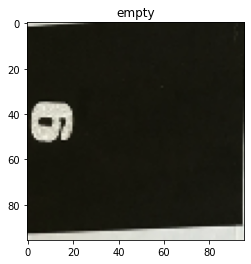

In [ ]:
from PIL import Image

for images, labels in testing_ds.take(1):
  start_time = time.time()
  prediction = classify_image(interpreter, images[0].numpy().astype('uint8'))
  end_time = time.time()

plt.title(['empty', 'parked'][int(prediction)])
plt.imshow(images[0].numpy().astype('uint8'))
print(f'Took {end_time-start_time}s to make inference')

# **Visualize quantized model predictions**

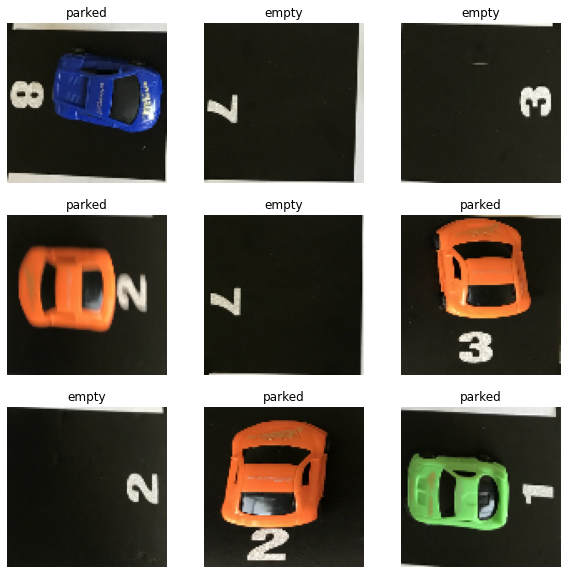

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in testing_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(['empty', 'parked'][int(classify_image(interpreter, images[i].numpy().reshape(1, 96, 96, 3)))])
    plt.axis("off")